In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from model_input import input_pipeline, preprocessing_op
from Skeleton import Skeleton

In [2]:
config = {}
config['img_height'] = 80
config['img_width'] = 80
config['img_num_channels'] = 3
config['num_epochs'] = 10
config['batch_size'] = 16
# Capacity of the queue which contains the samples read by data readers.
# Make sure that it has enough capacity.
config['ip_queue_capacity'] = config['batch_size']*10  
config['ip_num_read_threads'] = 6
# Directory of the data.
config['data_dir'] = "./train/"
# File naming
config['file_format'] = "dataTrain_%d.tfrecords"
# File IDs to be used for training.
config['file_ids'] = list(range(1,10))

# Create a list of TFRecord input files.
filenames = [os.path.join(config['data_dir'], config['file_format'] % i) for i in config['file_ids']]

# Create data loading operators. This will be represented as a node in the computational graph.
batch_samples_op, batch_skeleton_op, batch_labels_op, batch_seq_len_op = input_pipeline(filenames, config)

samples_placeholder = tf.placeholder(tf.uint8, [config['batch_size'], None, config['img_height'], config['img_width'], 6])
labels_placeholder = tf.placeholder(tf.int64, [config['batch_size']])
seq_len_placeholder = tf.placeholder(tf.int32, [config['batch_size']])

prep_op = tf.map_fn(fn=lambda x: preprocessing_op(x, config), elems=samples_placeholder, dtype=tf.float32)

# Create tensorflow session and initialize the variables (if any).
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
# Create threads to prefetch the data.
# https://www.tensorflow.org/programmers_guide/reading_data#creating_threads_to_prefetch_using_queuerunner_objects
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [3]:
# Fetch a batch of samples.
batch_samples, batch_skeleton, batch_labels, batch_seq_len = sess.run([batch_samples_op, batch_skeleton_op, batch_labels_op, batch_seq_len_op])

In [8]:
%%time
# Build skeleton
skeleton_imgs = np.zeros(batch_skeleton.shape[:2] + (80, 80), dtype=np.uint8)
for i in range(batch_skeleton.shape[0]):
    for j in range(batch_skeleton.shape[1]):
        skeleton = Skeleton(batch_skeleton[i][j])
        skeleton.resizePixelCoordinates()
        skeleton_img = skeleton.toImage(80, 80)
        skeleton_imgs[i, j, :, :] = skeleton_img
print(1)

1
CPU times: user 1.77 s, sys: 14 ms, total: 1.79 s
Wall time: 1.78 s


In [9]:
# Feed skeleton back in
batch_samples = sess.run(prep_op, feed_dict={
    samples_placeholder: np.concatenate((batch_samples, skeleton_imgs[..., np.newaxis]), axis=4) 
})

# Samples: 16
Sequence lengths: [62 82 84 63 62 73 98 76 81 57 54 59 70 73 63 58]
Sequence labels: [12 18 11  3 17  4 13 14 16 19 19  2  1 18 14  9]
Sequence type: <class 'numpy.ndarray'>
Sequence shape: (16, 98, 80, 80, 6)


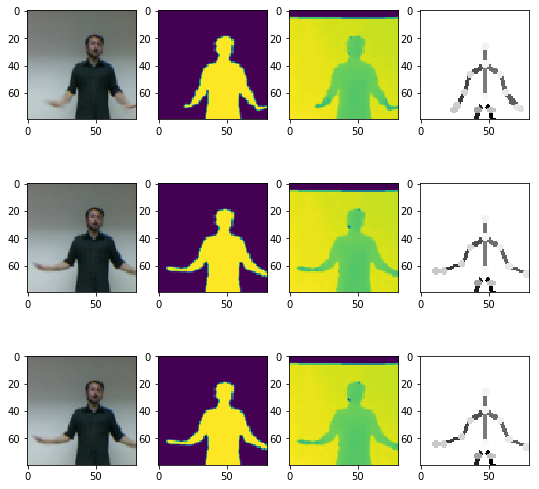

In [13]:
# Print 
print("# Samples: " + str(len(batch_samples)))
print("Sequence lengths: " + str(batch_seq_len))
print("Sequence labels: " + str(batch_labels))

# Note that the second dimension will give maximum-length in the batch, i.e., the padded sequence length.
print("Sequence type: " + str(type(batch_samples)))
print("Sequence shape: " + str(batch_samples.shape))

# Fetch first clips 11th frame.
plt.figure(figsize=(9,9))
plt.axis("off")

for frame in range(10, 13):
    plt.subplot2grid((3, 4), (frame-10, 0))
    plt.imshow(((batch_samples[i, frame, :, :, 2::-1]+1.) * 127.5).astype(np.uint8))
    
    plt.subplot2grid((3, 4), (frame-10, 1))
    plt.imshow(batch_samples[i, frame, :, :, 3])
    
    plt.subplot2grid((3, 4), (frame-10, 2))
    plt.imshow(batch_samples[i, frame, :, :, 4])
    
    plt.subplot2grid((3, 4), (frame-10, 3))
    plt.imshow(batch_samples[i, frame, :, :, 5], cmap='Greys', interpolation='nearest')
i += 1

In [32]:
batch_samples.shape

(16, 98, 80, 80, 6)

In [18]:
batch_samples = batch_samples[0]

In [19]:
batch_samples.shape

(16, 84, 80, 80, 6)

In [12]:
i=0